# Section 4.2 — Multiple linear regression

This notebook contains the code examples from [Section 4.2 Multiple linear regression]() from the **No Bullshit Guide to Statistics**.

#### Notebook setup

In [1]:
# load Python modules
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Figures setup
plt.clf()  # needed otherwise `sns.set_theme` doesn't work
from plot_helpers import RCPARAMS
# RCPARAMS.update({"figure.figsize": (10, 4)})   # good for screen
RCPARAMS.update({"figure.figsize": (5, 2.3)})  # good for print
sns.set_theme(
    context="paper",
    style="whitegrid",
    palette="colorblind",
    rc=RCPARAMS,
)

# High-resolution please
%config InlineBackend.figure_format = "retina"

# Where to store figures
DESTDIR = "figures/lm/multiple"

<Figure size 640x480 with 0 Axes>

In [3]:
# set random seed for repeatability
np.random.seed(42)

## Definitions

## Doctors dataset

In [4]:
doctors = pd.read_csv("../datasets/doctors.csv")
doctors.shape

(156, 9)

In [5]:
doctors.head()

,permit,loc,work,hours,caf,alc,weed,exrc,score
0,93273,rur,hos,21,2,0,5.0,0.0,63
1,90852,urb,cli,74,26,20,0.0,4.5,16
2,92744,urb,hos,63,25,1,0.0,7.0,58
3,73553,urb,eld,77,36,4,0.0,2.0,55
4,82441,rur,cli,36,22,9,0.0,7.5,47


## Multiple linear regression model
$\newcommand{\Err}{ {\Large \varepsilon}}$

$$
   Y  = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_p x_p + \Err,
$$

where $p$ is the number of predictors
and $\Err$ represents Gaussian noise $\Err \sim \mathcal{N}(0,\sigma)$.


### Model assumptions

- **(LIN)**
- **(INDEPɛ)**
- **(NORMɛ)**
- **(EQVARɛ)**
- **(NOCOL)**


## Example: linear model for doctors' sleep scores

We want to know the influence of drinking alcohol, smoking weed, and exercise on sleep score?

In [6]:
import statsmodels.formula.api as smf

formula = "score ~ 1 + alc + weed + exrc"
lm2 = smf.ols(formula, data=doctors).fit()
lm2.params

Intercept    60.452901
alc          -1.800101
weed         -1.021552
exrc          1.768289
dtype: float64

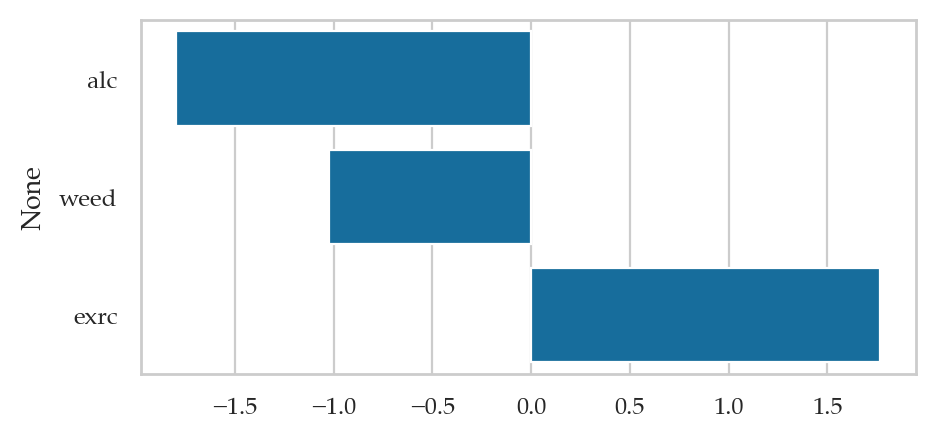

In [7]:
sns.barplot(x=lm2.params.values[1:],
            y=lm2.params.index[1:]);

### Partial regression plots

#### Partial regression plot for the predictor `alc` 

**Step 1**: Obtain the data for the x-axis,
residuals of the model `alc ~ 1 + others`

In [8]:
#######################################################
lm_alc = smf.ols("alc~1+weed+exrc", data=doctors).fit()
xrs = lm_alc.resid

**Step 2**: Obtain the data for the y-axis,
residuals of the model `score ~ 1 + others`

In [9]:
#######################################################
lm_score=smf.ols("score~1+weed+exrc",data=doctors).fit()
yrs = lm_score.resid

**Step 3**: Fit a linear model for the y-residuals versus the x-residuals.

In [10]:
dfrs = pd.DataFrame({"xrs": xrs, "yrs": yrs})
lm_resids = smf.ols("yrs ~ 1 + xrs", data=dfrs).fit()

**Step 4**: Draw a scatter plot of the residuals
and the best-fitting linear model to the residuals.

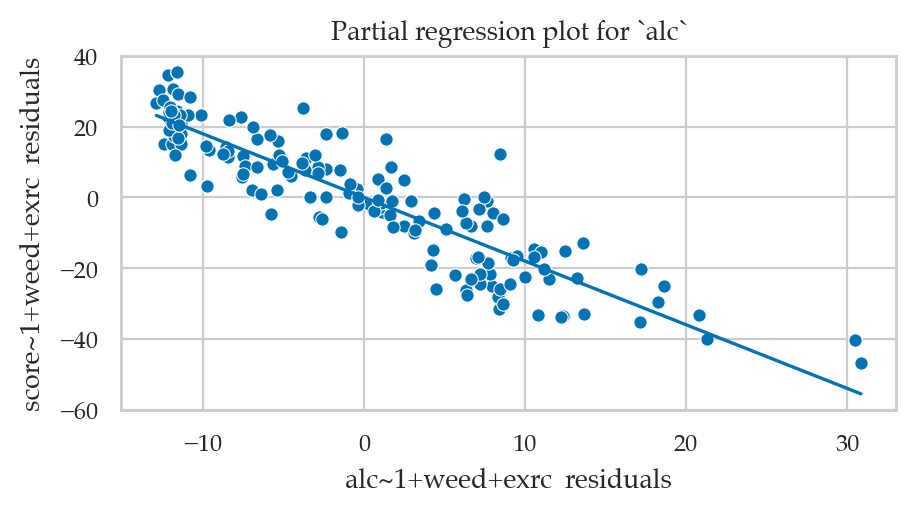

In [11]:
from ministats import plot_reg

ax = sns.scatterplot(x=xrs, y=yrs, color="C0")
plot_reg(lm_resids, ax=ax);
ax.set_xlabel("alc~1+weed+exrc  residuals")
ax.set_ylabel("score~1+weed+exrc  residuals")
ax.set_title("Partial regression plot for `alc`");

The slope parameter for the residuals model
is the same as the slope parameter of the `alc` predictor in the original model `lm2`.

In [12]:
lm_resids.params["xrs"], lm2.params["alc"]

(-1.8001013152459409, -1.8001013152459384)

#### Partial regression plot for the predictor `weed` 

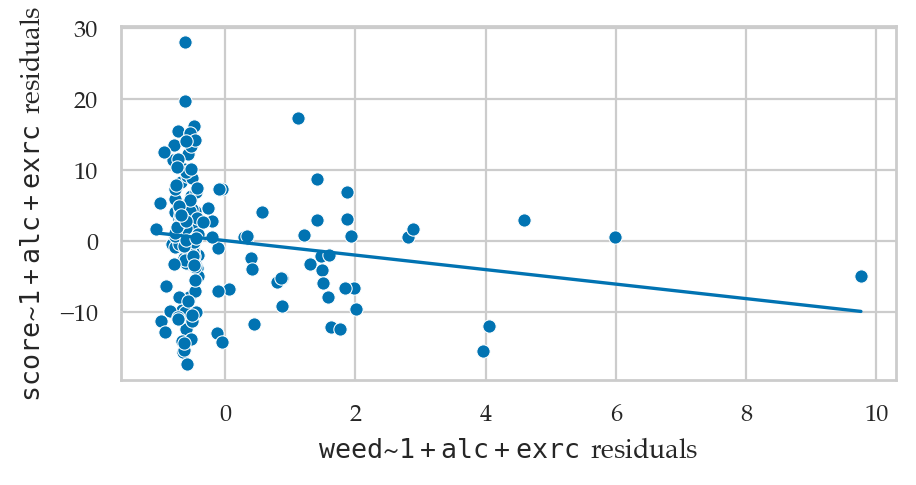

In [13]:
from ministats import plot_partreg
plot_partreg(lm2, pred="weed");

#### Partial regression plot for the predictor `exrc`

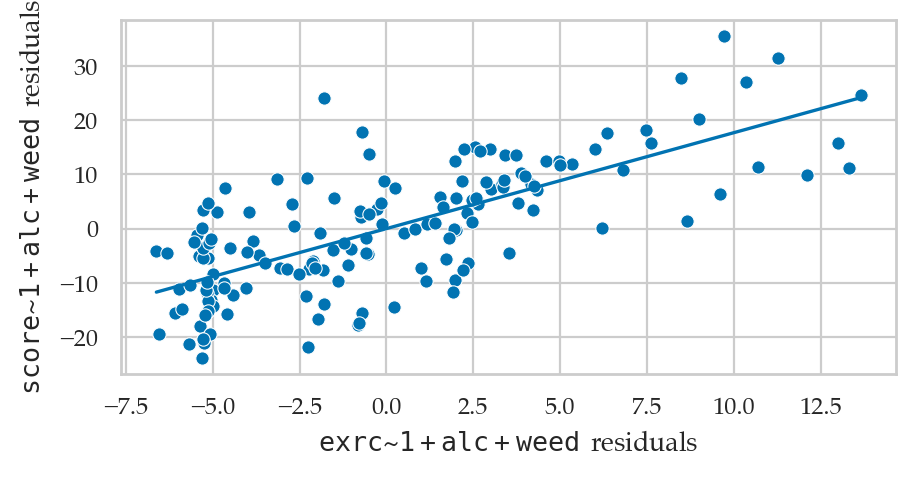

In [14]:
plot_partreg(lm2, pred="exrc");

#### (BONUS TOPIC) Partial regression plots using `statsmodels`

The function `plot_partregress` defined in `statsmodels.graphics.api`
performs the same steps as the function `plot_partreg` we used above.
but is a little more awkward to use.

When calling the function `plot_partregress`,
you must provide the following arguments:
- the outcome variable (`endog`)
- the predictor you're interested in (`exog_i`)
- the predictors you want to *regress out* (`exog_others`)
- the data frame that contains all these variable (`data`)


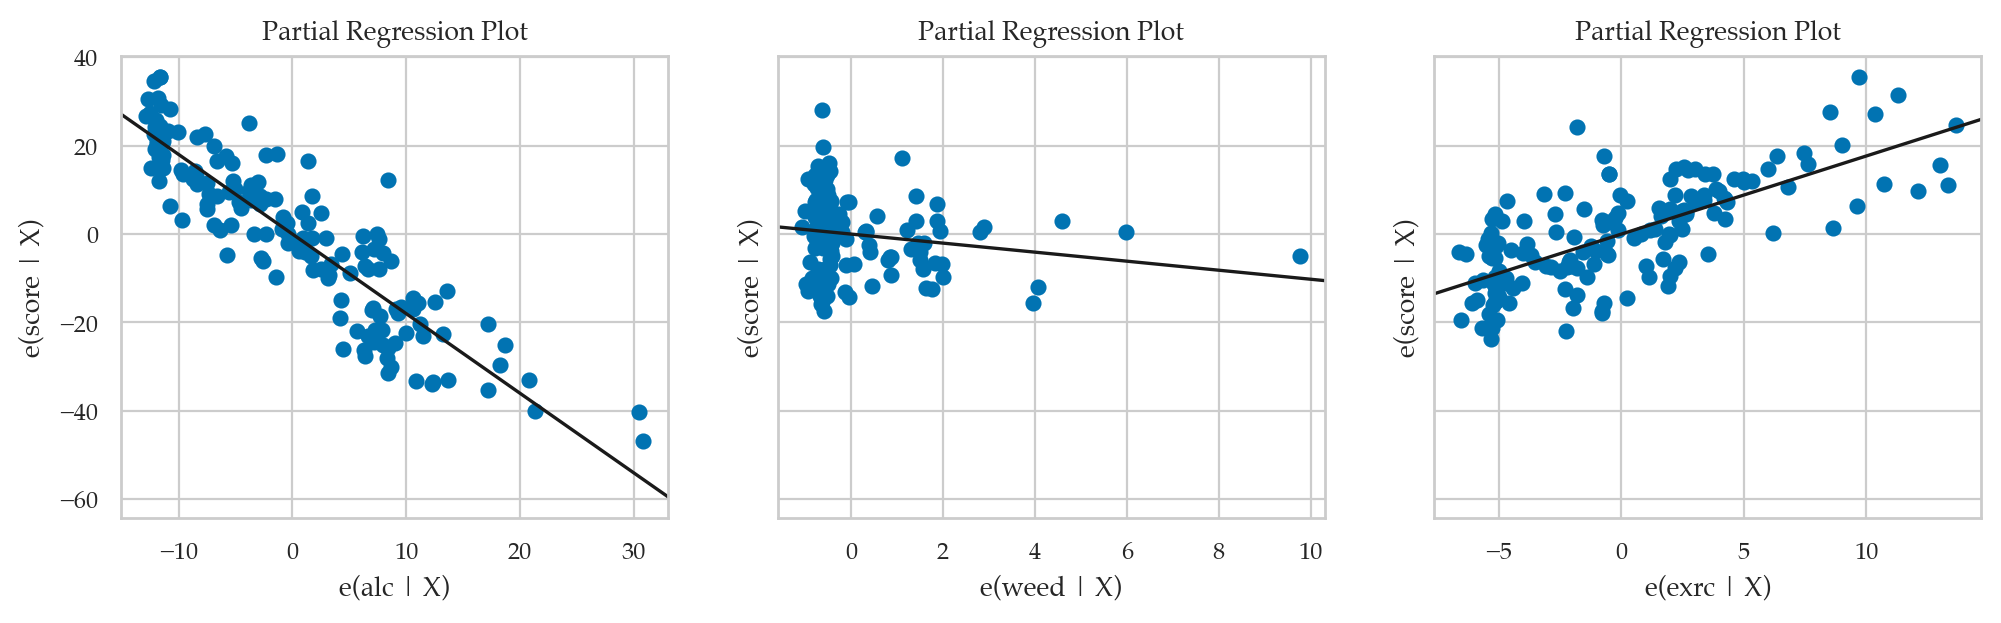

In [15]:
from statsmodels.graphics.api import plot_partregress

with plt.rc_context({"figure.figsize":(12,3)}):
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True)
    plot_partregress("score", "alc",  exog_others=["weed", "exrc"], data=doctors, obs_labels=False, ax=ax1)
    plot_partregress("score", "weed", exog_others=["alc",  "exrc"], data=doctors, obs_labels=False, ax=ax2)
    plot_partregress("score", "exrc", exog_others=["alc",  "weed"], data=doctors, obs_labels=False, ax=ax3)

The notation $|\textrm{X}$ you see in the axis labels stands for "given all other predictors,"
and is different for each subplot.
For example,
in the leftmost partial regression plot,
the predictor we are focussing on is `alc`,
so the other variables ($|\textrm{X}$) are `weed` and `exrc`.

### Plot residuals

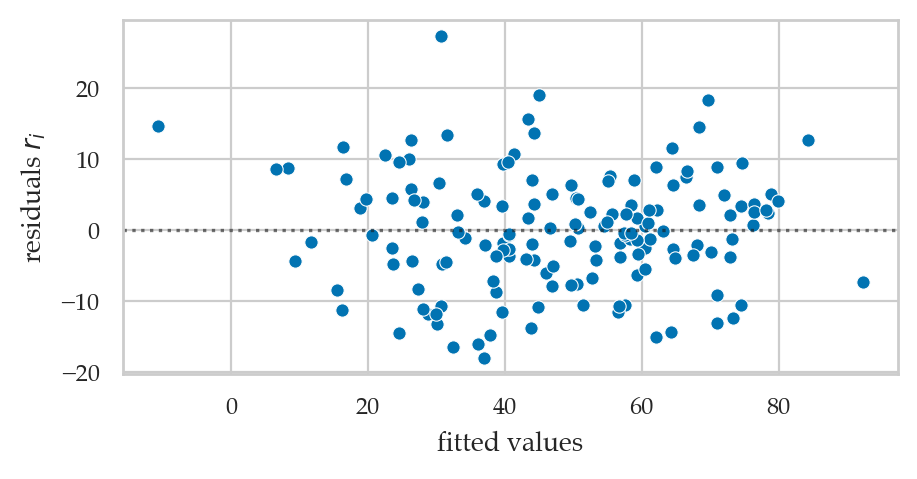

In [16]:
from ministats import plot_resid
plot_resid(lm2);

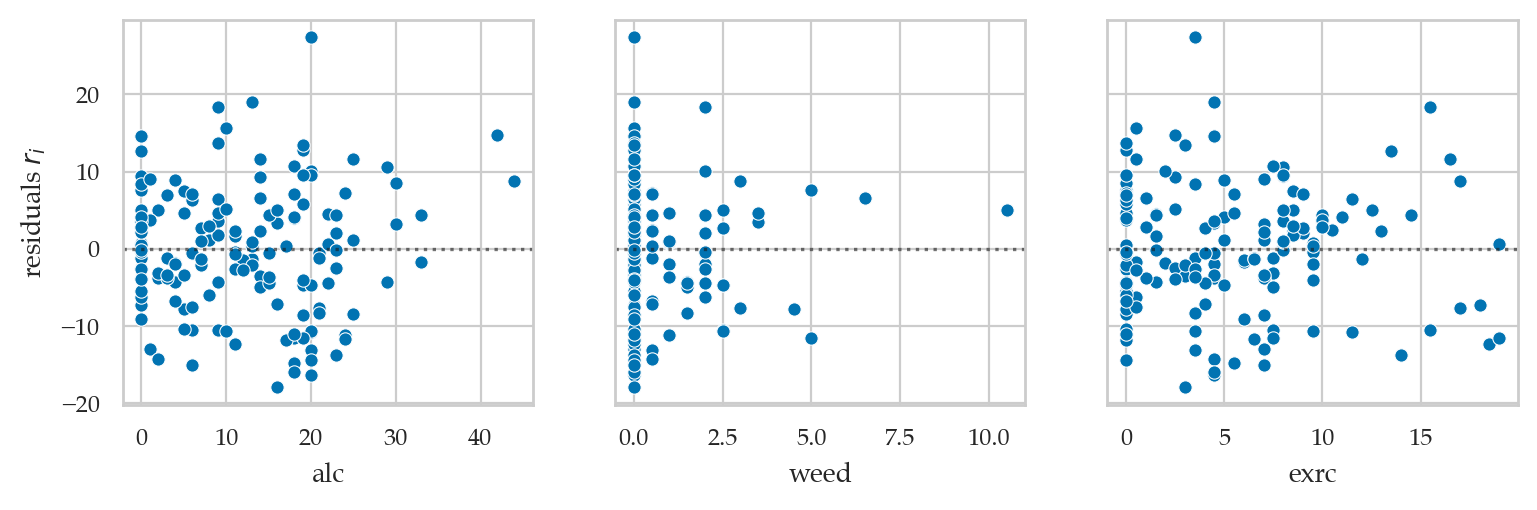

In [17]:
fig, (ax1,ax2,ax3) = plt.subplots(1, 3, sharey=True, figsize=(9,2.5))
plot_resid(lm2, pred="alc",  ax=ax1)
plot_resid(lm2, pred="weed", ax=ax2)
plot_resid(lm2, pred="exrc", ax=ax3);

### Model summary table

In [18]:
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     270.3
Date:                Fri, 19 Jul 2024   Prob (F-statistic):           1.05e-60
Time:                        09:45:00   Log-Likelihood:                -547.63
No. Observations:                 156   AIC:                             1103.
Df Residuals:                     152   BIC:                             1115.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     60.4529      1.289     46.885      0.000      57.905      63.000
alc           -1.8001      0.070    -25.726      0.000      -1.938      -1.662
weed          -1.0216      0.476     -2.145      0.034      -1.962      -0.081
exrc           1.7683      0.138     12.809      0.000       1.496       2.041
==============================================================================
Omnibus:                        1.140   Durbin-Watson:                   1.828
Prob(Omnibus):                  0.565   Jarque-Bera (JB):                0.900
Skew:                           0.182   Prob(JB):                        0.638
Kurtosis:                       3.075   Cond. No.                         31.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Explanations

### Nonlinear terms in linear regression

#### Example: polynomial regression

In [19]:
howell30 = pd.read_csv("../datasets/howell30.csv")
len(howell30)

270

In [20]:
# Fit quadratic model
formula2 = "height ~ 1 + age + np.square(age)"
lmq = smf.ols(formula2, data=howell30).fit()
lmq.params

Intercept         64.708568
age                7.100854
np.square(age)    -0.137302
dtype: float64

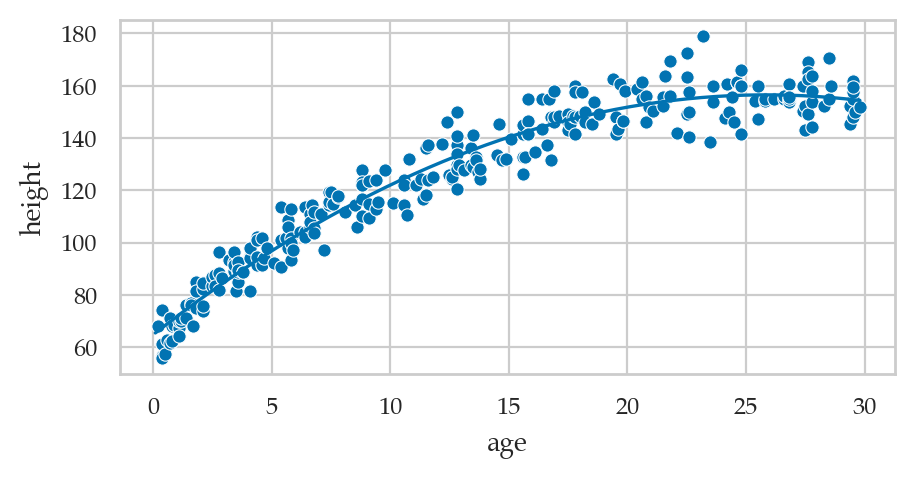

In [21]:
# Plot the data
sns.scatterplot(data=howell30, x="age", y="height");

# Plot the best-fit quadratic model
intercept, b_lin, b_quad = lmq.params
ages = np.linspace(0.1, howell30["age"].max())
heighthats = intercept + b_lin*ages + b_quad*ages**2
sns.lineplot(x=ages, y=heighthats, color="b");

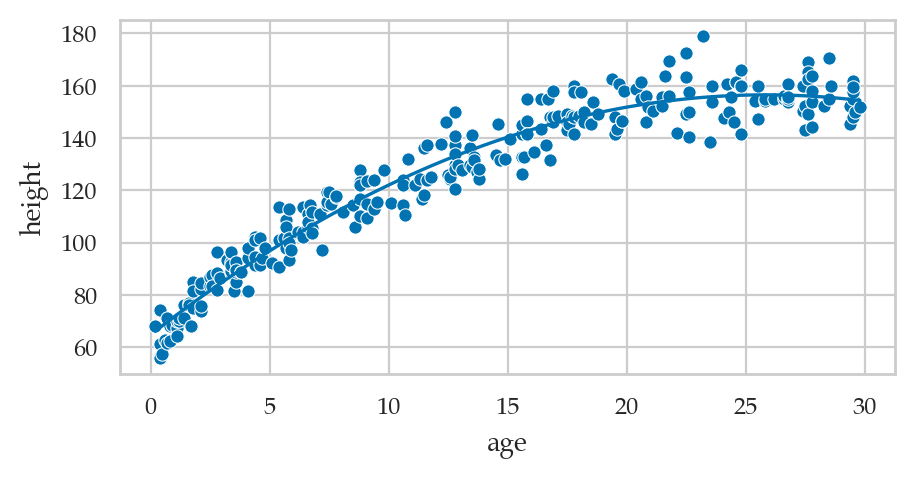

In [22]:
# ALT. using `plot_reg` function
from ministats import plot_reg
plot_reg(lmq);

### Feature engineering and transformed variables

#### Bonus example: polynomial regression up to degree 3

In [23]:
formula3 = "height ~ 1 + age + np.power(age,2) + np.power(age,3)"
exlm3 = smf.ols(formula3, data=howell30).fit()
exlm3.params

Intercept           63.461484
age                  7.636139
np.power(age, 2)    -0.183218
np.power(age, 3)     0.001033
dtype: float64

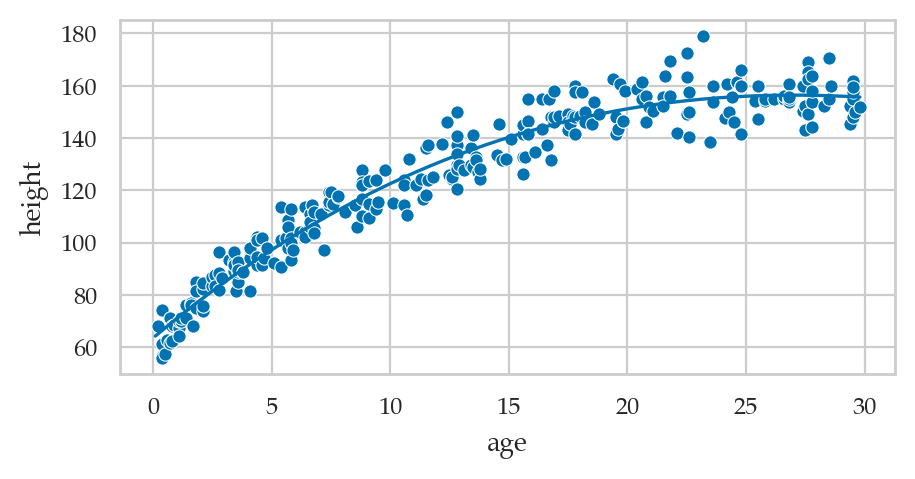

In [24]:
sns.scatterplot(data=howell30, x="age", y="height")
sns.lineplot(x=ages, y=exlm3.predict({"age":ages}));

## Discussion

## Exercises

### Exercise E??: marketing dataset

In [25]:
marketing = pd.read_csv("../datasets/exercises/marketing.csv")
formula_mkt = "sales ~ 1 + youtube + facebook + newspaper"
lm_mkt2 = smf.ols(formula_mkt, data=marketing).fit()
lm_mkt2.params

Intercept    3.526667
youtube      0.045765
facebook     0.188530
newspaper   -0.001037
dtype: float64

## Links